# ÉVALUATION DE L’ÉQUITÉ DES MODÈLES D’APPRENTISSAGE PROFOND PRÉENTRAÎNÉS
# II. Apprentissage de ResNet50 sans fine tuning
# Projet de 15 crédits de Wajih Mghazli

In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

2023-05-03 17:34:32.396389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:34:34.700866: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 17:34:47.468421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/export/livia/home/vision/Wmghazli/miniconda3/envs/tf/lib/
2023-05-03 17:34:47.469309:

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [2]:
FEATURES_PATH = 'dataset/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = 'dataset/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = 'dataset/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [4]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [5]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

### 1. 4. 2 Reconstruction de la base de données

In [6]:
train_images = np.concatenate([ raf_db['images_gender']['male'],
                                raf_db['images_gender']['female'],
                                raf_db['images_race']['caucasian'],
                                raf_db['images_race']['asian'],
                                raf_db['images_race']['african']
])

train_labels = np.concatenate([ raf_db['labels_gender']['male'],
                                raf_db['labels_gender']['female'],
                                raf_db['labels_race']['caucasian'],
                                raf_db['labels_race']['asian'],
                                raf_db['labels_race']['african']
])

## 2. Apprentissage de ResNet50 sans fine tuning

In [8]:
# Instantiate the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top of the ResNet50 baseline model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model pre-trained layers (so that we do not lose their weights)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpoints'
checkpoint_file = checkpoint_dir + '/best_vanilla_resnet50.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

2023-05-03 17:39:29.946250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:39:35.947105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-05-03 17:39:35.949774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46705 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6
2023-05-03 17:39:35.951544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/t

In [9]:
# Train the model
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/100


2023-05-03 17:40:06.056828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-03 17:40:13.209268: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-03 17:40:16.860653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-03 17:40:17.861399: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f242da2c910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-03 17:40:17.861433: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-05-03 17:40:17.861439: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-05-03 17:40:17.861444: I tensorflow/compiler/xla/service/service

614/614 [==============================] - 53s 55ms/step - loss: 1.1938 - accuracy: 0.5855 - val_loss: 1.0303 - val_accuracy: 0.6183
Epoch 2/100
614/614 [==============================] - 31s 51ms/step - loss: 0.8954 - accuracy: 0.6731 - val_loss: 1.0217 - val_accuracy: 0.6337
Epoch 3/100
614/614 [==============================] - 30s 50ms/step - loss: 0.7533 - accuracy: 0.7227 - val_loss: 0.7536 - val_accuracy: 0.7270
Epoch 4/100
614/614 [==============================] - 32s 52ms/step - loss: 0.6359 - accuracy: 0.7716 - val_loss: 0.6758 - val_accuracy: 0.7604
Epoch 5/100
614/614 [==============================] - 31s 51ms/step - loss: 0.5236 - accuracy: 0.8100 - val_loss: 0.5895 - val_accuracy: 0.7828
Epoch 6/100
614/614 [==============================] - 32s 52ms/step - loss: 0.4211 - accuracy: 0.8492 - val_loss: 0.5221 - val_accuracy: 0.8106
Epoch 7/100
614/614 [==============================] - 32s 52ms/step - loss: 0.3336 - accuracy: 0.8847 - val_loss: 0.3945 - val_accuracy: 0.85

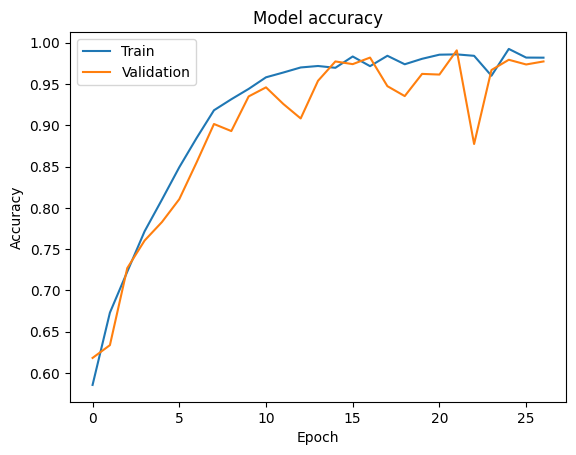

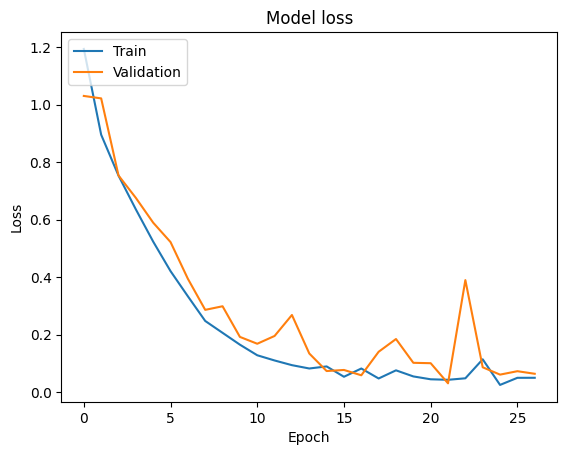

In [10]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()